## TTS inference with Tacotron2+ WaveGlow on Google COLAB

by Hyungon Ryu | Sr. Solution Architect at NVIDIA


In this COLAB Jupyter, I'll demonstrate how to generate voice from input text with Tacotron2 + WaveGlow Model.

## DevOps

Check Available GPU. COLAB provide Tesla K80.

In [1]:
!nvidia-smi

Wed Nov 28 16:19:29 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### set max clock

In [2]:
%%bash
#check the environemnt 
echo "Check H/W"
lscpu | grep 'CPU(s):            '
lscpu | grep GHz
echo "memory" && free -m | cut -c-49 |  head -n 2 
echo "storage" && df -h |  cut -c-60 | head -n 2
df -h |  grep '/dev/sda1'
echo " " && nvidia-smi -L | cut -c-17
echo "confure Max Application Clock for K80 875Mhz"
nvidia-smi -ac 2505,875 && nvidia-smi -pm 1
echo " " &&echo "Check S/W"
cat /etc/*-release | grep PRETTY_NAME
python --version 
nvcc --version | grep  tools

Check H/W
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
memory
              total        used        free      
Mem:          13022         426       10954      
storage
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  7.6G  333G   3% /
/dev/sda1       365G   11G  355G   3% /opt/bin
 
GPU 0: Tesla K80 
confure Max Application Clock for K80 875Mhz
Applications clocks set to "(MEM 2505, SM 875)" for GPU 00000000:00:04.0


All done.
Enabled persistence mode for GPU 00000000:00:04.0.
All done.
 
Check S/W
PRETTY_NAME="Ubuntu 18.04.1 LTS"
Python 3.6.7
Cuda compilation tools, release 9.2, V9.2.148


### install pytorch 1.0
Current implementation of Tacotron2 and Waveglow model  require pytorch 1.0.
It will takes 30 seconds. 

pytorch 1.0 build number : `torch-nightly-1.0.0.dev20181128`

In [3]:
%%time
%%bash
pip install numpy
pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly-1.0.0.dev20181128-cp36-cp36m-linux_x86_64.whl

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly-1.0.0.dev20181128-cp36-cp36m-linux_x86_64.whl


tcmalloc: large alloc 1073750016 bytes == 0x63a0a000 @  0x7fd7739ed2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


CPU times: user 7.57 ms, sys: 5.15 ms, total: 12.7 ms
Wall time: 38.4 s


### install required python utilities
It will takes 30 seconds. 

In [4]:
%%time 
%%bash
pip install -q \
 inflect==0.2.5 \
 librosa==0.6.0 \
 scipy==1.0.0 \
 tensorboardX==1.1 \
 Unidecode==1.0.22 

CPU times: user 4.01 ms, sys: 6.54 ms, total: 10.5 ms
Wall time: 21.9 s


## Git clone Waveglow and tacotron model

 if you have any problem, use exact commit. 
 - Tacotron2 : commit `6e430556bd4e1404c4dbf7cf4c790b4dd53ee93d`
 - WaveGlow : commit `6c6d5fcce1351203c2029dcf0fefd06f5647b948`
 


In [5]:
%%bash
rm -rf waveglow
git clone https://github.com/NVIDIA/waveglow.git
cd waveglow
git submodule init
git submodule update --remote --merge

Submodule path 'tacotron2': checked out '6e430556bd4e1404c4dbf7cf4c790b4dd53ee93d'


Cloning into 'waveglow'...
Submodule 'tacotron2' (http://github.com/NVIDIA/tacotron2) registered for path 'tacotron2'
Cloning into '/content/waveglow/tacotron2'...


## Download Checkpoint file


### pythonscript

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)




### Tacotron2 

Tacotron2 Model checkpoint file : *`tacotron2_statedict.pt`* (108MB)

In [7]:
%%time
destination="tacotron2_statedict.pt"
file_id="1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
download_file_from_google_drive(file_id, destination)

CPU times: user 298 ms, sys: 256 ms, total: 554 ms
Wall time: 1.21 s


### WaveGlow
WaveGlow Model  checkpoint file : *`waveglow_old.pt`*  (2GB)
It will takes 15 seconds.

In [8]:
%%time
destination="waveglow_old.pt"
file_id="1cjKPHbtAMh_4HTHmuIGNkbOkPBD9qwhj"
download_file_from_google_drive(file_id, destination)

CPU times: user 4.67 s, sys: 5.06 s, total: 9.74 s
Wall time: 14.4 s


### configure 


In [0]:
import os
import sys
import time
import numpy as np
from scipy.io.wavfile import write

import warnings
warnings.filterwarnings('ignore')

##### for figure

In [0]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd


%matplotlib inline

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

##### waveglow and tacotron model

In [0]:
import torch
sys.path.insert(0, 'waveglow')
sys.path.insert(0, 'waveglow/tacotron2')
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

##### Setup Hparams

In [0]:
hparams = create_hparams()
hparams.sampling_rate = 22050

### Load Tacotron2 model

In [16]:
%%time
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

CPU times: user 2.87 s, sys: 1.16 s, total: 4.03 s
Wall time: 4.65 s


### Load WaveGlow model

In [17]:
%%time
waveglow_path ="waveglow_old.pt"
waveglow = torch.load(waveglow_path)['model']
waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval()

CPU times: user 596 ms, sys: 1.58 s, total: 2.18 s
Wall time: 2.18 s


### Generate Mel Spectrogram from input text


#### input sentence

In [0]:
text = "There's a way to measure the acute emotional intelligence that has never gone out of style."

#### text preprocessing 

In [0]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]

#### load sequence

In [0]:
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

#### generate Mel spectrogram from input text 

In [21]:
%%time
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

CPU times: user 976 ms, sys: 196 ms, total: 1.17 s
Wall time: 1.18 s


####  plot results

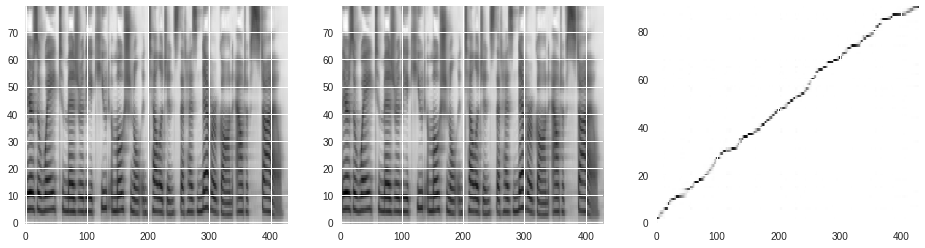

In [22]:
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

### Synthesize audio from Mel spectrogram using WaveGlow¶
it will takes 17 sec on K80. it include redundant memory copy time.

In [23]:
%%time
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

CPU times: user 31.9 s, sys: 21.9 s, total: 53.8 s
Wall time: 53.8 s


#### check audio

In [25]:
print(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

There's a way to measure the acute emotional intelligence that has never gone out of style.


## Measure exact inference time

#### reduce batch to simplify code

In [26]:
print(mel_outputs_postnet.size())
print(mel_outputs_postnet[-1, :, :].size())

torch.Size([1, 80, 429])
torch.Size([80, 429])


#### configure waveglow 

### Generate Audio from Mel spectrogram
in general, it will takes 6.6 seconds on COLAB with Tesla K80 ( Kepler Architecture). if you would use Tesla V100 (Volta Architecture) or Tesla T4(Turing Architecture), you could generate audio in real-time. 

In [33]:
%%time

from mel2samp import MAX_WAV_VALUE
sampling_rate=22050
sigma=0.6

mel = mel_outputs_postnet[-1, :, :]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
start= time.perf_counter()
with torch.no_grad():
    audio2 = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
duration= time.perf_counter() - start
print("inference time {:.2f}s/it".format(duration))

inference time 6.54s/it
CPU times: user 3.62 s, sys: 2.92 s, total: 6.54 s
Wall time: 6.54 s



It will take 30 seconds to download 

In [34]:
%%time
audio2=audio2.data.cpu().numpy()

CPU times: user 25.3 s, sys: 17.5 s, total: 42.8 s
Wall time: 42.9 s


### check audio

In [35]:
print(text)
ipd.Audio(audio2 , rate=sampling_rate)

There's a way to measure the acute emotional intelligence that has never gone out of style.
